# Introduction

This notebook shows how to compute the claims reserving according to the well known Fisher-Lange approach and the Collective Risk Model approach in [1].


# Install GEMact

If you are using GEMact from Colab you may need to install the package and restart the kernel. 
Indeed, we require a more advanced version of matplot than the version provided from the default.

In [ ]:
import os

try:
     import gemact
except:
      !pip install gemact== 0.3.1
      exit()


In [ ]:
import gemact

In [ ]:
gemact.__version__

'0.1.3'

# Fisher-Lange

The Fisher-Lange model for claims reserving requires a lot of inputs. 
In GEMAct we provide plain vanilla triangles from [2.] that can be used to test our package functionalities. 


Average cost methods predict separately frequency and severity amounts in the lower triangle. 

\begin{equation}
  X_{i, j}=n_{i, j} \cdot m_{i, j} 
\end{equation}

Denote the incremental payments $X_{i,j}$ in each cell as the product between the number of claims in the $i,j$, $n_{i,j}$ cell and the severity average cost $m_{i,j}$.

\begin{equation}
\mbox{aliq}_{i, j}=\frac{\sum_{h=j+1}^{n-i} n_{i, h}+r_{i, n-i}}{r_{i, j}}
\end{equation}

The $n-1$ dimensional vector $\alpha$: $\alpha_j=\mathbb{E}\left(\mbox{aliq}_{i, j}\right)$.

In [ ]:
# Dati Fisher-Lange
ip_ = gemact.gemdata.incremental_payments
in_ = gemact.gemdata.incurred_number
cp_ = gemact.gemdata.cased_payments
cn_ = gemact.gemdata.cased_number
reported_ = gemact.gemdata.reported_claims

In order to define an aggregate reserving method for claims reserving in gemact we need to instance the AggregateData class.

ad = gemact.AggregateData(
            incremental_payments=ip_,
            cased_payments=cp_,
            cased_number=cn_,
            reported_claims=reported_,
            incurred_number=in_)

The model is then created within the ReservingModel class. Consider the following assumptions:

In [ ]:
rm_='fisherlange' # reserving model
tail_=True #boolean
claims_inflation= gemact.gemdata.claims_inflation

rm = gemact.ReservingModel(tail=tail_,
                 reserving_method="rm_",
                 claims_inflation=claims_inflation)

LossReserve can now be initialized with the proper parameters. 

In [ ]:
lr = gemact.LossReserve(data=ad,
                        reservingmodel=rm)


INFO:lossreserve|A correct 1-d vector for Reported claims was provided. \n Make sure the reported claims on the last position corresponds to the most recent data


In [ ]:
lr.alpha_fl

array([0.91515711, 0.8652144 , 0.98573158, 1.025986  , 1.05345412,
       1.06701538, 1.06664371, 1.06990381, 1.01141058, 1.0227052 ,
       1.01851852, 1.        ])

In the final print the claims reserve and the ultimate cost are displayed.

In [ ]:
lr.print_loss_reserve_specs()

                                     time          ultimate FL           reserve FL
                                      0.0              86841.0               1068.0
                                      1.0      98161.954237115   1837.9542371150096
                                      2.0   107140.16750863047   2133.1675086304704
                                      3.0   117422.58617931853    2747.586179318526
                                      4.0   122773.45583108162    4485.455831081627
                                      5.0   138139.75521426514    6000.755214265135
                                      6.0   148047.83900370973    9756.839003709756
                                      7.0   145115.34662015972   15214.346620159751
                                      8.0    146550.9374895417   21764.937489541713
                                      9.0    155700.0816042082   33900.081604208186
                                     10.0   164364.24141488288   52022.24141

The alpha coefficients are plotted with GEMAct. In case the practioner is looking for more sofisticated estimates, it is possible to provide personalized values for those.

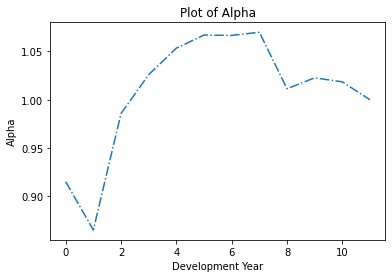

In [ ]:
lr.alpha_plot()

The settlement speed on the triangle is plotted out from the year of start specified from the user.

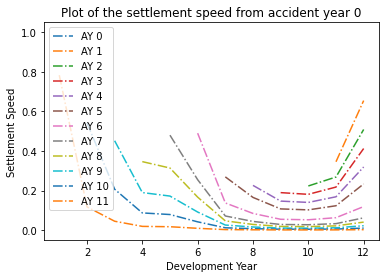

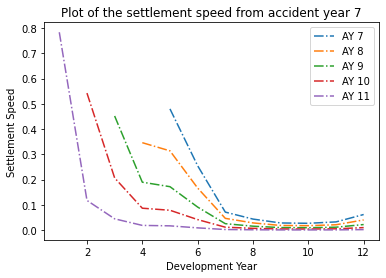

In [ ]:
lr.ss_plot()
lr.ss_plot(start_=7)

# Collective risk model for claims reserving

The collective risk model we implemented from [1] requires additional information on the frequency and severity structural variables.

Each cell is modeled as a collective risk model:

\begin{equation}
X_{i, j}=\sum_{h=1}^{K_{i, j}} Z_{i, j, h}
\end{equation}

Frequency and severity assumptions are listed below.

* **Frequency**: $K_{i, j} \sim \text { Poisson }\left(\hat{n}_{i, j} \cdot q\right)$ with $q \sim \text { Gamma }$, $\mathbb{E}\left[q\right]=1$. 

* **Severity**: $\mathbb{E}\left[Z_{i,j}\right]=m_{i,j}$ and $c_{Z_{i, j}}=\hat{c}_{Z_{j}} \cdot r$ with $r \sim \text { Gamma }$, $\mathbb{E}\left[r\right]=1$


Please refer to the GEMAct [api reference guide](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html). for the **gamma** parametrization.

Similarly to the Fisher-Lange tutorial we can compute the reserve with the collective risk model for claims reserving. Observe that the two models adopt the same data.

In [ ]:
mixing_fq_par = {'a': 1 / .08 ** 2,  # mix frequency
                         'scale': .08 ** 2}

mixing_sev_par = {'a': 1 / .08 ** 2, 'scale': .08 ** 2}  # mix severity
czj = gemact.gemdata.czj
claims_inflation=gemact.gemdata.claims_inflation

rm = gemact.ReservingModel(tail=True,
            reserving_method="crm",
            claims_inflation=claims_inflation,
            mixing_fq_par=mixing_fq_par,
            mixing_sev_par=mixing_sev_par,
            czj=czj)

In [ ]:
#Loss reserving: instance lr

lm = gemact.LossReserve(data=ad,
                        reservingmodel=rm,
                        ntr_sim=1000,
                        random_seed=1)

#The progress bar below gives insights on the simulation

INFO:lossreserve|A correct 1-d vector for Reported claims was provided. \n Make sure the reported claims on the last position corresponds to the most recent data


[============================================================================= ] 100%


The new final screen compares the model with the fisher-lange results.


In [ ]:
lr.print_loss_reserve_specs()

                                     time          ultimate FL           reserve FL         ultimate CRM          reserve CRM             msep CRM
                                      0.0              86841.0               1068.0    86516.22780775833   1470.2278077583296    317.2140138815026
                                      1.0      98161.954237115   1837.9542371150096    97730.38698443415   1862.3869844341552   400.81502073077945
                                      2.0   107140.16750863047   2133.1675086304704   106597.93443409832    2149.934434098324   409.52168026094944
                                      3.0   117422.58617931853    2747.586179318526   116582.44257704115   2780.4425770411426    416.7414764994397
                                      4.0   122773.45583108162    4485.455831081627   121668.71859068517    4504.718590685162   475.62097408382226
                                      5.0   138139.75521426514    6000.755214265135    135955.8526636557    6083.85266

Inside lr the practitioner can find all the results modeled during the process.


In [ ]:
print(lr.predicted_i_numbers) #predicted numbers
print(lr.predicted_i_payments) #predicted payments
#crm only
print(lr.m_sep,lr.skewness) #msep


[[3.44330000e+04 1.37960000e+04 1.58900000e+03 5.68000000e+02
  2.78000000e+02 1.52000000e+02 1.04000000e+02 5.50000000e+01
  3.00000000e+01 3.10000000e+01 1.80000000e+01 1.90000000e+01
  3.60000000e+01]
 [3.54750000e+04 1.37180000e+04 1.50100000e+03 5.48000000e+02
  2.09000000e+02 1.34000000e+02 5.10000000e+01 4.40000000e+01
  2.70000000e+01 2.00000000e+01 1.60000000e+01 1.51296296e+01
  2.86666667e+01]
 [3.70040000e+04 1.38200000e+04 1.52700000e+03 4.36000000e+02
  1.94000000e+02 7.20000000e+01 4.60000000e+01 2.90000000e+01
  1.70000000e+01 1.70000000e+01 1.16335553e+01 1.39993415e+01
  2.65250682e+01]
 [3.70380000e+04 1.36310000e+04 1.46300000e+03 5.00000000e+02
  1.64000000e+02 8.00000000e+01 6.30000000e+01 4.00000000e+01
  2.60000000e+01 1.26430958e+01 1.20689468e+01 1.45232737e+01
  2.75177818e+01]
 [3.68490000e+04 1.34160000e+04 1.56400000e+03 4.22000000e+02
  1.82000000e+02 1.07000000e+02 8.10000000e+01 4.20000000e+01
  2.46656809e+01 1.59976524e+01 1.52711661e+01 1.83766926e+0

# References

```{bibliography}
1. Ricotta, Alessandro, and Clemente, Gian Paolo . "An Extension of Collective Risk Model for Stochastic Claim Reserving." Journal of Applied Finance and Banking 6.5 (2016): 45.
2. Savelli, Nino, and Clemente, Gian Paolo . "Lezioni di matematica attuariale delle assicurazioni danni." EDUCatt-Ente per il diritto allo studio universitario dell'Università Cattolica, 2014.

```